<a href="https://www.kaggle.com/code/danish2op/nn-for-mnist?scriptVersionId=182865517" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt


In [2]:
data = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
data = np.array(data)
m, n = data.shape
np.random.shuffle(data) 


In [3]:
data_dev = data[0:28000].T
Y_dev = data_dev[0]
X_dev = data_dev[1:n]
X_dev = X_dev / 255.

In [4]:
data_train = data[1000:m].T
Y_train = data_train[0]
X_train = data_train[1:n]
X_train = X_train / 255.
_, m_train = X_train.shape

In [5]:
def init_params():
    W1 = np.random.rand(128, 784) - 0.5
    b1 = np.random.rand(128, 1) - 0.5
    W2 = np.random.rand(64, 128) - 0.5
    b2 = np.random.rand(64, 1) - 0.5
    W3 = np.random.rand(10, 64) - 0.5
    b3 = np.random.rand(10, 1) - 0.5
    return W1, b1, W2, b2, W3, b3




In [6]:
# Activation functions and their derivatives
def LeakyReLU(Z, alpha=0.01):
    return np.maximum(alpha * Z, Z)

def ELU(Z, alpha=1.0):
    return np.where(Z > 0, Z, alpha * (np.exp(Z) - 1))

def ReLU(Z):
    return np.maximum(0, Z)

def LeakyReLU_deriv(Z, alpha=0.01):
    return np.where(Z > 0, 1, alpha)

def ELU_deriv(Z, alpha=1.0):
    return np.where(Z > 0, 1, alpha * np.exp(Z))

def ReLU_deriv(Z):
    return np.where(Z > 0, 1, 0)

def softmax(Z):
    A = np.exp(Z) / np.sum(np.exp(Z), axis=0)
    return A

def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))

def sigmoid_deriv(Z):
    return sigmoid(Z) * (1 - sigmoid(Z))


In [7]:
def forward_prop(W1, b1, W2, b2, W3, b3, X, activation_hidden1, activation_hidden2):
    Z1 = W1.dot(X) + b1
    A1 = activation_hidden1(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = activation_hidden2(Z2)
    Z3 = W3.dot(A2) + b3
    A3 = softmax(Z3)
    return Z1, A1, Z2, A2, Z3, A3


In [8]:
def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y


In [9]:
def backward_prop(Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, X, Y, activation_hidden1_deriv, activation_hidden2_deriv):
    one_hot_Y = one_hot(Y)
    dZ3 = A3 - one_hot_Y
    dW3 = 1 / m * dZ3.dot(A2.T)
    db3 = 1 / m * np.sum(dZ3, axis=1, keepdims=True)
    dZ2 = W3.T.dot(dZ3) * activation_hidden2_deriv(Z2)
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = W2.T.dot(dZ2) * activation_hidden1_deriv(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1, axis=1, keepdims=True)
    return dW1, db1, dW2, db2, dW3, db3


In [10]:
def update_params(W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1    
    W2 = W2 - alpha * dW2  
    b2 = b2 - alpha * db2
    W3 = W3 - alpha * dW3
    b3 = b3 - alpha * db3
    return W1, b1, W2, b2, W3, b3


In [11]:
def get_accuracy(predictions, Y):
    return np.sum(predictions == Y) / Y.size


In [12]:
def gradient_descent(X, Y, alpha, iterations, activation_hidden1, activation_hidden2, activation_hidden1_deriv, activation_hidden2_deriv):
    W1, b1, W2, b2, W3, b3 = init_params()
    accuracy_list = []
    for i in range(iterations):
        Z1, A1, Z2, A2, Z3, A3 = forward_prop(W1, b1, W2, b2, W3, b3, X, activation_hidden1, activation_hidden2)
        dW1, db1, dW2, db2, dW3, db3 = backward_prop(Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, X, Y, activation_hidden1_deriv, activation_hidden2_deriv)
        W1, b1, W2, b2, W3, b3 = update_params(W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3, alpha)
        if i % 10 == 0:
            predictions = np.argmax(A3, axis=0)
            accuracy = get_accuracy(predictions, Y)
            accuracy_list.append(accuracy)
            print(f"Iteration {i}: {accuracy}")
    return W1, b1, W2, b2, W3, b3, accuracy_list


In [13]:
def make_predictions(X, W1, b1, W2, b2, W3, b3, activation_hidden1, activation_hidden2):
    _, _, _, _, _, A3 = forward_prop(W1, b1, W2, b2, W3, b3, X, activation_hidden1, activation_hidden2)
    predictions = np.argmax(A3, axis=0)
    return predictions


In [14]:
print("training with LeakyReLU and ELU")
W1, b1, W2, b2, W3, b3, accuracy_list_leaky_elu = gradient_descent(
    X_dev, Y_dev, 0.10, 500, LeakyReLU, ELU, LeakyReLU_deriv, ELU_deriv)

predictions_test_leaky_elu = make_predictions(X_dev, W1, b1, W2, b2, W3, b3, LeakyReLU, ELU)


training with LeakyReLU and ELU
Iteration 0: 0.09607142857142857
Iteration 10: 0.5277142857142857
Iteration 20: 0.6412142857142857
Iteration 30: 0.6989642857142857
Iteration 40: 0.733
Iteration 50: 0.7558571428571429
Iteration 60: 0.7737142857142857
Iteration 70: 0.7871428571428571
Iteration 80: 0.7978571428571428
Iteration 90: 0.80675
Iteration 100: 0.8138928571428572
Iteration 110: 0.8213571428571429
Iteration 120: 0.8278928571428571
Iteration 130: 0.8339642857142857
Iteration 140: 0.8381071428571428
Iteration 150: 0.8420714285714286
Iteration 160: 0.8465357142857143
Iteration 170: 0.85075
Iteration 180: 0.85375
Iteration 190: 0.8569642857142857
Iteration 200: 0.8605
Iteration 210: 0.8633571428571428
Iteration 220: 0.8657857142857143
Iteration 230: 0.8681428571428571
Iteration 240: 0.8706785714285714
Iteration 250: 0.8726785714285714
Iteration 260: 0.8750714285714286
Iteration 270: 0.8770357142857143
Iteration 280: 0.8787142857142857
Iteration 290: 0.8806071428571428
Iteration 300: 0

In [15]:
# Training and testing with ReLU
print("training with only ReLU")
W1, b1, W2, b2, W3, b3, accuracy_list_relu = gradient_descent(
    X_train, Y_train, 0.10, 500, ReLU, ReLU, ReLU_deriv, ReLU_deriv)

predictions_test_relu = make_predictions(X_dev, W1, b1, W2, b2, W3, b3, ReLU, ReLU)


training with only ReLU
Iteration 0: 0.08214634146341464
Iteration 10: 0.4937073170731707
Iteration 20: 0.620390243902439
Iteration 30: 0.6848048780487805
Iteration 40: 0.7225853658536585
Iteration 50: 0.7496829268292683
Iteration 60: 0.7695853658536586
Iteration 70: 0.7865609756097561
Iteration 80: 0.7997804878048781
Iteration 90: 0.8093414634146342
Iteration 100: 0.8181463414634146
Iteration 110: 0.8260975609756097
Iteration 120: 0.8322195121951219
Iteration 130: 0.8378292682926829
Iteration 140: 0.8429512195121951
Iteration 150: 0.8477073170731707
Iteration 160: 0.8519512195121951
Iteration 170: 0.8555121951219512
Iteration 180: 0.8589268292682927
Iteration 190: 0.8622682926829268
Iteration 200: 0.8656341463414634
Iteration 210: 0.8682682926829268
Iteration 220: 0.8714878048780488
Iteration 230: 0.8738780487804878
Iteration 240: 0.8760731707317073
Iteration 250: 0.8782682926829268
Iteration 260: 0.880390243902439
Iteration 270: 0.8822926829268293
Iteration 280: 0.8837804878048781
It

In [16]:
print("training with Sigmoid")
W1, b1, W2, b2, W3, b3, accuracy_list_sigmoid = gradient_descent(
    X_dev, Y_dev, 0.10, 500, sigmoid, sigmoid, sigmoid_deriv, sigmoid_deriv)

predictions_test_sigmoid = make_predictions(X_dev, W1, b1, W2, b2, W3, b3, sigmoid, sigmoid)


training with Sigmoid
Iteration 0: 0.12675
Iteration 10: 0.10735714285714286
Iteration 20: 0.17239285714285715
Iteration 30: 0.21928571428571428
Iteration 40: 0.26421428571428573
Iteration 50: 0.30742857142857144
Iteration 60: 0.35235714285714287
Iteration 70: 0.3916428571428571
Iteration 80: 0.4317142857142857
Iteration 90: 0.46032142857142855
Iteration 100: 0.4895357142857143
Iteration 110: 0.5144285714285715
Iteration 120: 0.53625
Iteration 130: 0.5545357142857142
Iteration 140: 0.5718928571428571
Iteration 150: 0.5881428571428572
Iteration 160: 0.6021428571428571
Iteration 170: 0.6158214285714285
Iteration 180: 0.6278928571428571
Iteration 190: 0.6399642857142858
Iteration 200: 0.6512857142857142
Iteration 210: 0.6603214285714286
Iteration 220: 0.6691785714285714
Iteration 230: 0.6783214285714285
Iteration 240: 0.6876785714285715
Iteration 250: 0.6954642857142858
Iteration 260: 0.7028214285714286
Iteration 270: 0.7099285714285715
Iteration 280: 0.71675
Iteration 290: 0.722178571428

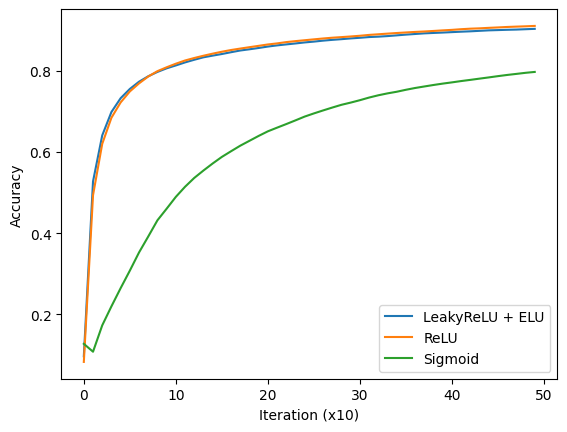

In [17]:
plt.plot(accuracy_list_leaky_elu, label='LeakyReLU + ELU')
plt.plot(accuracy_list_relu, label='ReLU')
plt.plot(accuracy_list_sigmoid, label='Sigmoid')
plt.xlabel('Iteration (x10)')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
